### Simple example of fitting an NVP flow to a 2D dataset

Paper is [here](https://arxiv.org/pdf/1605.08803).

In [1]:
import os
import json
import torch
from torch import nn
from torch import distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm.notebook import trange

FIGS_DIR = os.path.join(os.getcwd(), "Youlin/figs/moons/")
DATA_DIR = os.path.join(os.getcwd(), "Youlin/data/")
if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
def convert(x):
    # Convert a numpy array to a torch tensor with float32 entries
    return torch.as_tensor(x).float()

In [2]:
print(device)

cuda


##### Model

In [3]:
class RealNVP(nn.Module):
    def __init__(self, net_s, net_t, mask, prior):
        super(RealNVP, self).__init__()
        # Base distribution, a data-dimensional Gaussian
        self.prior = prior
        # Masks are not to be optimised
        self.mask = nn.Parameter(mask, requires_grad=False) 
        # The s and t nets that parameterise the scale and shift
        # change of variables according to inputs, here we are
        # duplicating the networks for each layer.
        self.t = torch.nn.ModuleList(
            [net_t() for _ in range(len(masks))]
        )
        self.s = torch.nn.ModuleList(
            [net_s() for _ in range(len(masks))]
        )

    def reverse(self, z, c):
        # Map from Gaussian distributed z to data x
        x = z
        for i in range(len(self.t)):
            x_ = x * self.mask[i]
            xc = torch.cat((x_, c), dim=1) # add additional dim with cat for NN
            s = self.s[i](xc) * (1 - self.mask[i])
            t = self.t[i](xc) * (1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t) # eq. 29
        return x

    def forward(self, x, c):
        # Map from data x to Gaussian distributed z
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            zc = torch.cat((z_, c), dim=1)
            s = self.s[i](zc) * (1 - self.mask[i])
            t = self.t[i](zc) * (1 - self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_ # eq. 30
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x, c):
        # Calculate log-probability of x under flow distribution
        z, log_det_J = self.forward(x, c)
        return self.prior.log_prob(z) + log_det_J

    def sample(self, n, c):
        # Sample n points from flow distribution fit to data
        z = self.prior.sample((n, 1))
        # Reshape z to adjust NN
        z = torch.squeeze(z) 
        x = self.reverse(z, c)
        return x

##### Setup

In [4]:
H = 256            # Hidden dimension
L = 4              # Number of transforms in flow
n_data = 10000     # Number of datapoints in training set, initially 10000
n_steps = 10000    # Number of batches to run for, initially 10000
batch_size = 1000  # Number of datapoints in batch

# Scaling and shifting networks for flow change of variables
net_s = lambda: nn.Sequential(
    nn.Linear(3, H), nn.LeakyReLU(), # 3 inputs due to added c parameter
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, 2), nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(3, H), nn.LeakyReLU(),
    nn.Linear(H, H), nn.LeakyReLU(),
    nn.Linear(H, 2)
)

# Masking for NVP flow model, for splitting and scaling data
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * L)).float()

# Base distribution for normalizing flow
prior = distributions.MultivariateNormal(
    torch.zeros(2).to(device), torch.eye(2).to(device)
)

# Build the model
flow = RealNVP(net_s, net_t, masks, prior).to(device)

# Save the model's state dictionary
model_path = 'saved_nvp.pth'
torch.save(flow.state_dict(), model_path)

# Get some training data
X, Y = make_moons(n_data, noise=0.05)

# Scale the data to [-1, 1] 
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Convert it to tensors and move to device
X, Y = convert(X).to(device), convert(Y).to(device)

# Reshape Y to adjust NN
Y = torch.unsqueeze(Y, 1)

def get_data(n_size, batch_size, X, Y):
    # A simple dataloader
    ix = torch.randint(low=0, high=n_size, size=(batch_size,)) # when considering whole dataset, n_size = n_data
    x, y = X[ix], Y[ix]
    return x, y

# For training and validation, define additional data loaders
# Training data loader
def get_train_data(batch_size):
    return get_data(n_train, batch_size, X_train, Y_train)

# Validation data loader
def get_val_data(batch_size):
    return get_data(n_val, batch_size, X_val, Y_val)

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

In [5]:
X, Y

(tensor([[ 0.8524, -0.2729],
         [ 0.6657, -0.4747],
         [ 0.1604, -0.5757],
         ...,
         [ 0.6162, -0.4729],
         [-0.6201,  0.1950],
         [ 0.6862, -0.4636]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [0.],
         [1.]], device='cuda:0'))

In [6]:
# Y_zero = torch.zeros(Y.shape)
# Y_one = torch.ones(Y.shape)

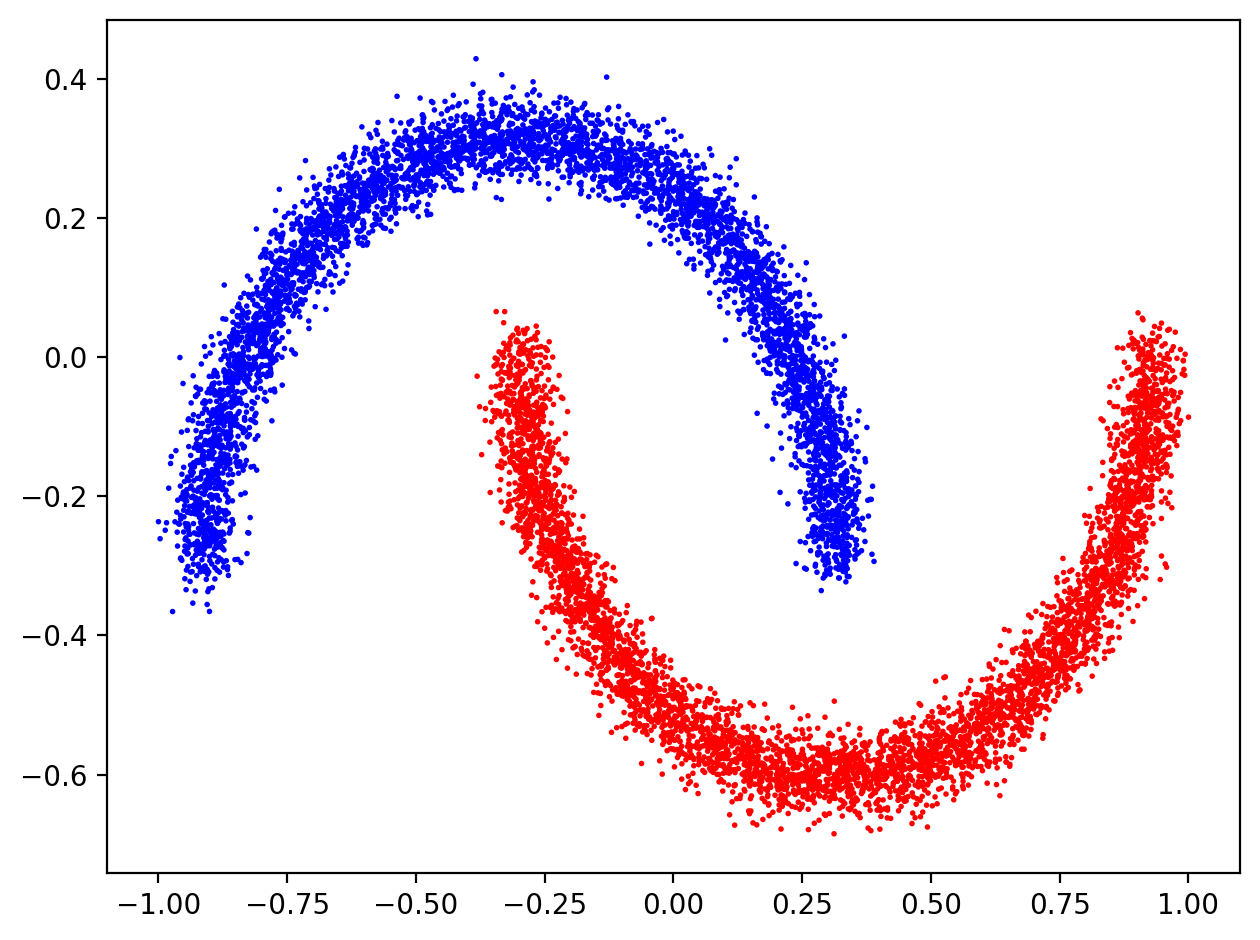

In [7]:
# Plot some training samples for comparison
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*X.cpu().numpy().T, c=Y.cpu().numpy(), s=1., cmap="bwr")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "train_samples_moons.png"))
plt.show()

#### Train + Validation (using train_test_split)

In [8]:
# Load train_test_split package to split dataset
from sklearn.model_selection import train_test_split

X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to tensors and move to the appropriate device
X_train = convert(X_train).to(device)
Y_train = convert(Y_train).to(device).unsqueeze(1)
X_val = convert(X_val).to(device)
Y_val = convert(Y_val).to(device).unsqueeze(1)
n_train = len(X_train)
n_val = len(X_val)

# Define parameters
losses = []
val_losses = []

# parameters for early stopping in validation loop
best_val_loss = float('inf')
patience = batch_size # sets same as batch_size
patience_counter = 0

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3, weight_decay=1e-4) # weight decay for L2 regularization

In [9]:
with trange(n_steps) as T:
    for t in T:
        x, y = get_train_data(batch_size)
        # Train with gpu if available
        x = x.to(device)
        y = y.to(device)
        
        # Training step
        flow.train() # Inherited from nn.Module, sets into training mode
        loss = -flow.log_prob(x, y).mean() # eq. 26

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        T.set_postfix(loss=f"{loss:.3E}")
        
        # Validation step
        if t % 100 == 0:
            x, y = get_val_data(batch_size)
            # Train with gpu if available
            x = x.to(device)
            y = y.to(device)
            
            flow.eval()  # Inherited from nn.Module, sets into evaluation/validation mode
            with torch.no_grad():
                val_loss = -flow.log_prob(x, y).mean() # eq. 26
                val_losses.append(val_loss.item())
                T.set_postfix(val_loss=f"{val_loss:.3E}")

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0  # Reset counter if validation loss improves
                else:
                    patience_counter += 1  # Increment counter if validation loss doesn't improve

                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # Sampling and visualization step
        if t % 500 == 0:
            # Sample from the flow
            x, y = get_val_data(batch_size)
            y = y.to(device)
            with torch.no_grad():
                samples = flow.sample(batch_size, y)
                samples = samples.cpu().detach().numpy()

            fig, ax = plt.subplots(1, 1, dpi=100)
            ax.scatter(*samples.T, s=1.)
            plt.tight_layout()
            plt.savefig(os.path.join(FIGS_DIR, f"flow_samples_step_{t}.png"))
            plt.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

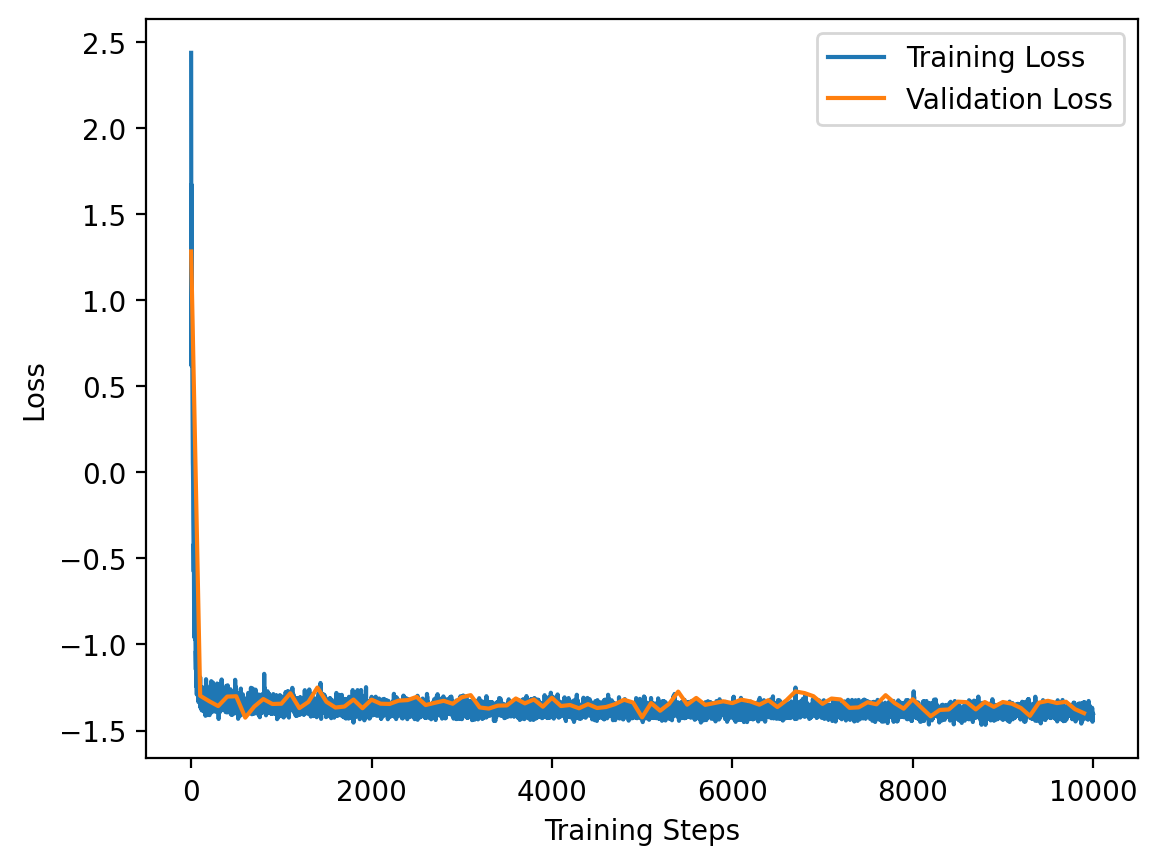

In [10]:
# Plot training and validation losses
plt.figure(dpi=200)
plt.plot(losses, label='Training Loss')
plt.plot(np.arange(0, len(val_losses)) * 100, val_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(FIGS_DIR, "training_validation_loss.png"))
plt.show()

#### Inference

(10000, 2) (10000,)
(100, 100) (100, 100)
torch.Size([10000, 2]) torch.Size([10000, 1])


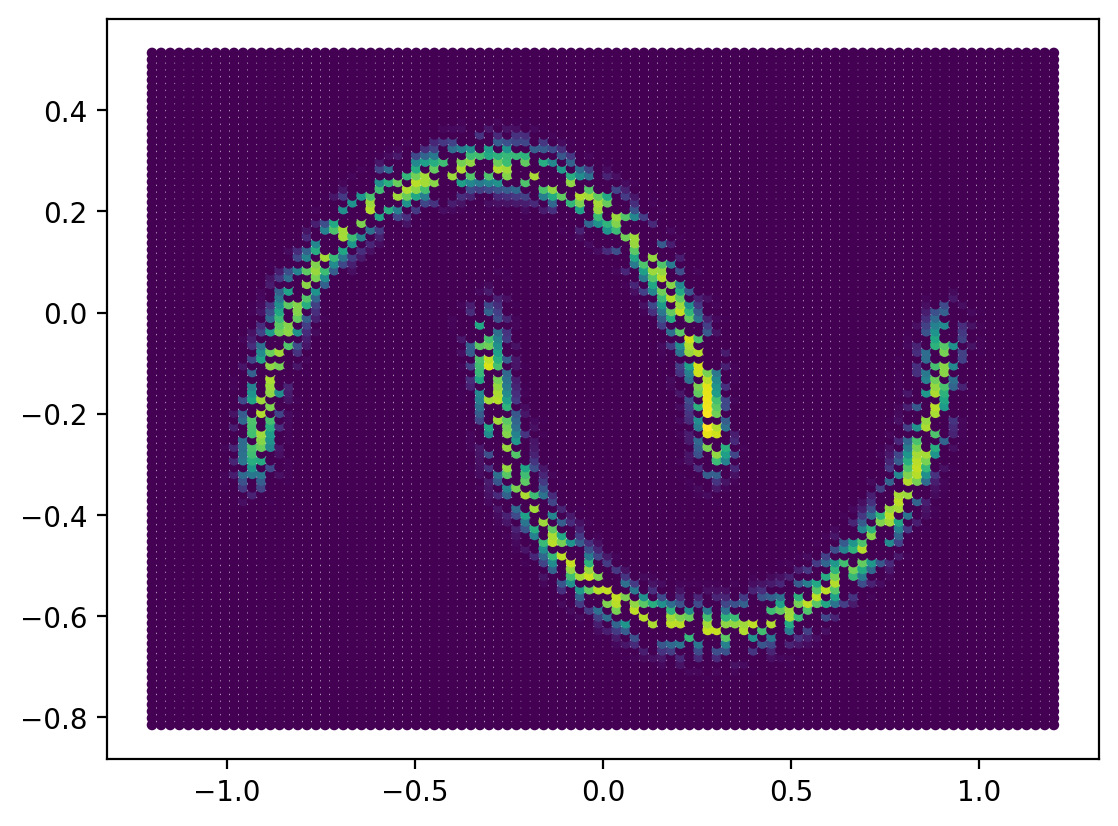

In [11]:
# Plot the likelihood over data space
X, Y = make_moons(n_data, noise=0.05) # n_data has to be 10000 (due to X_, Y_)
print(X.shape, Y.shape)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Get a grid of points spanning the data space
X1, X2 = X.T
dx = 0.1 * (X1.max() - X1.min()) # Same span as data plus a little bit extra
dy = 0.1 * (X2.max() - X2.min())

# np.ravel() returns a contiguous flattened array, flattens (100, 100) into (1, 10000)
X_, Y_ = np.mgrid[X1.min() - dx:X1.max() + dx:100j, X2.min() - dy:X2.max() + dy:100j]
print(X_.shape, Y_.shape)
X = torch.as_tensor(np.vstack([X_.ravel(), Y_.ravel()])).float().T
Y = convert(Y).to(device).unsqueeze(1)
print(X.shape, Y.shape)


# Flow likelihood
L_x = np.exp(flow.log_prob(X.to(device), Y).cpu().detach().numpy())

plt.figure(dpi=200)
plt.scatter(*X.numpy().T, c=L_x, s=8.)
plt.savefig(os.path.join(FIGS_DIR, "likelihood_moons.png"))
plt.show()

Without consideration of parameter c

torch.Size([1000, 2]) torch.Size([1000, 1])


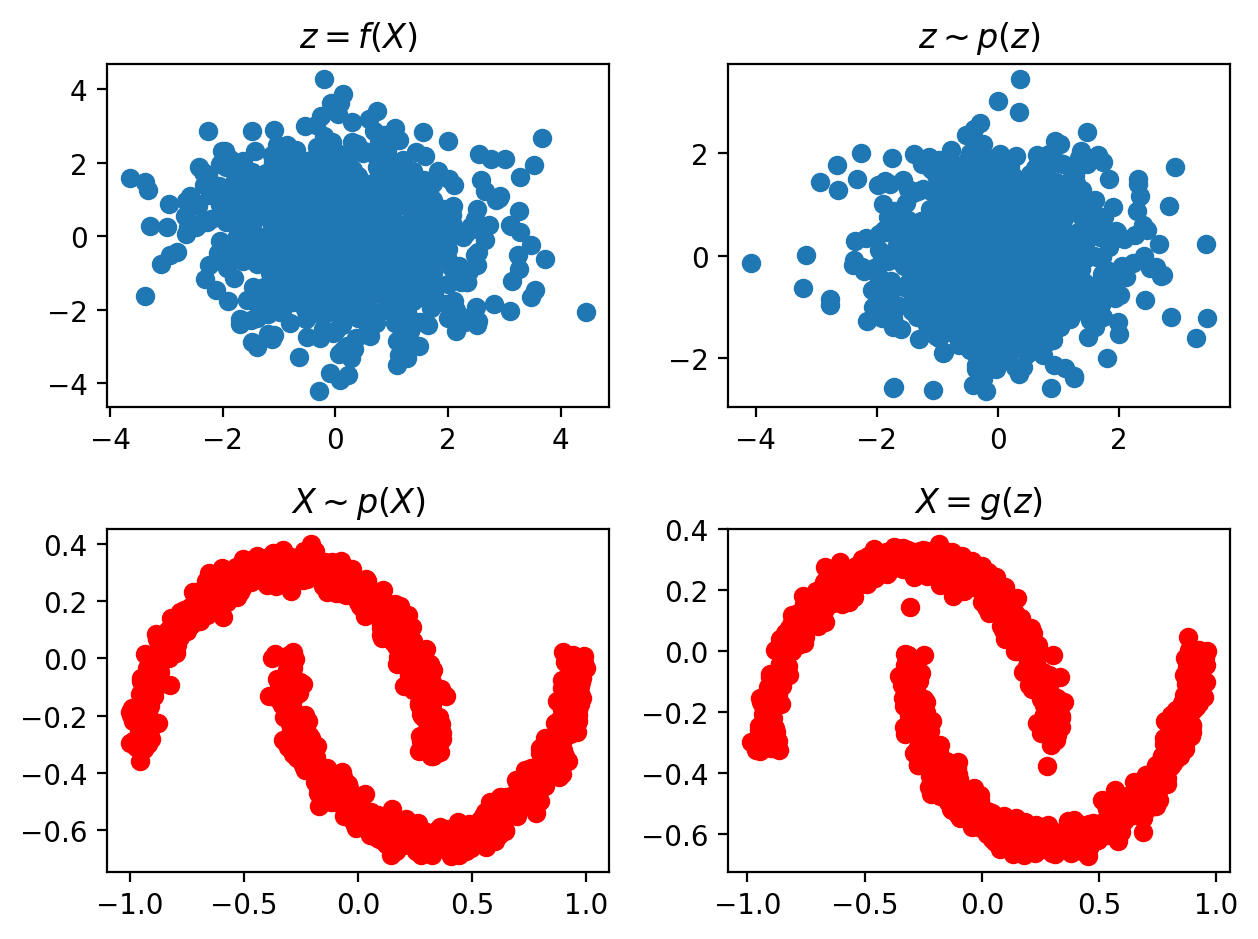

In [12]:
X, Y = make_moons(batch_size, noise=0.05) # here instead of n_data, takes 1000 (batch_size?)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

X = torch.as_tensor(X).float().to(device)
Y = convert(Y).to(device)
Y = torch.unsqueeze(Y, 1)
print(X.shape, Y.shape)

plt.figure(dpi=200)

# Data mapped to prior 'latent' space
z = flow.forward(X, Y)[0].cpu().detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

# Prior
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

# Truth distribution
plt.subplot(223)
X = X.cpu()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

# Generated
plt.subplot(224)
X = flow.sample(1000, Y).cpu().detach().numpy().squeeze()
plt.scatter(X[:, 0], X[:, 1], c='r')
plt.title(r'$X = g(z)$')

plt.savefig(os.path.join(FIGS_DIR, "flow_mappings.png"))
plt.tight_layout()
plt.show()

With introduced parameter c

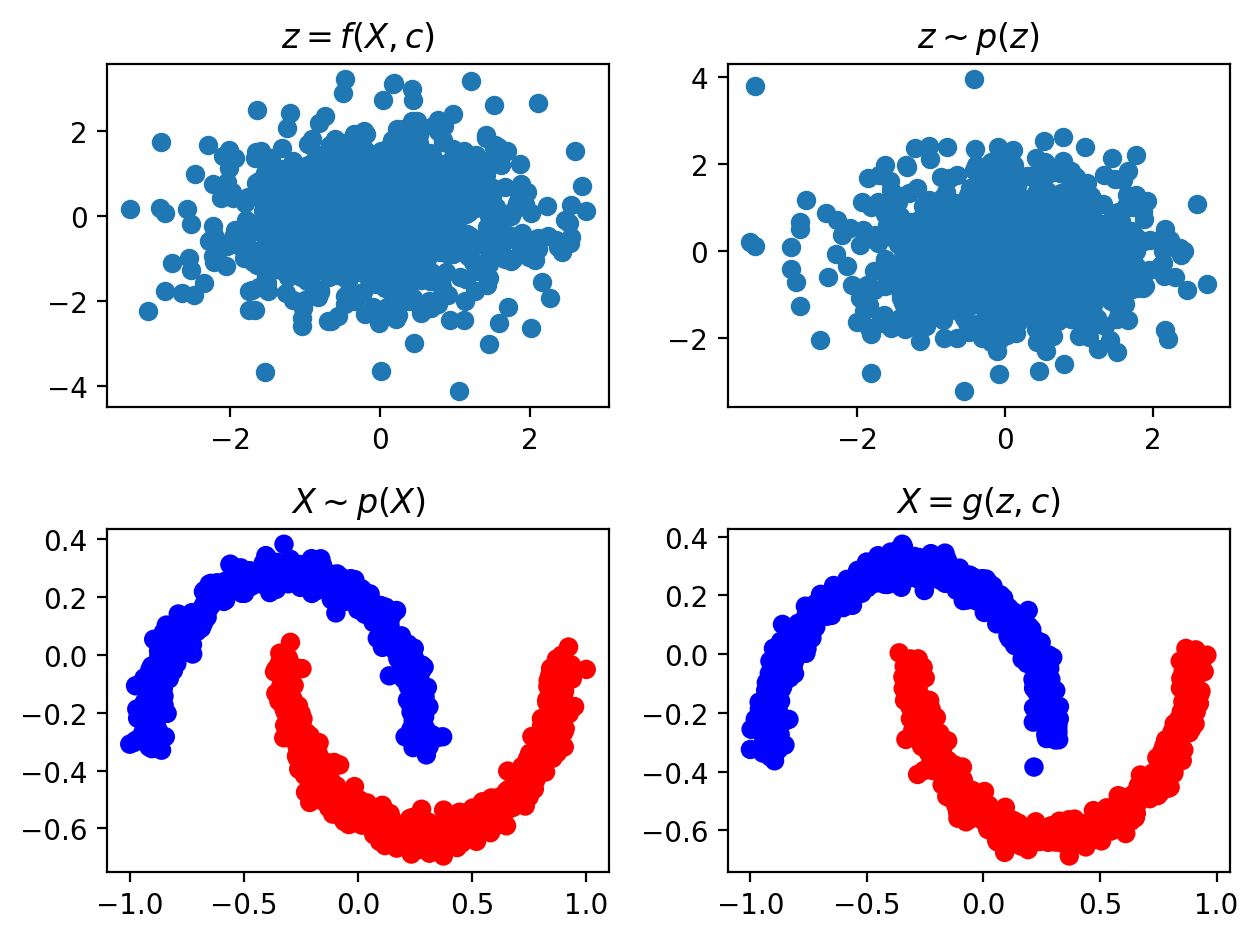

In [13]:
# Number of data points
n_data = 1000
n_visualize = 1000
batch_size = n_visualize

# Generate moons data and condition labels
X, Y = make_moons(n_data, noise=0.05)
X = 2. * (X - X.min()) / (X.max() - X.min()) - 1.

# Convert to tensors and move to the appropriate device
X = convert(X).to(device)
Y = convert(Y).to(device).unsqueeze(1)

plt.figure(dpi=200)

# Data mapped to prior 'latent' space
z = flow.forward(X, Y)[0].cpu().detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X, c)$')

# Prior
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), n_visualize)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

# Truth distribution
plt.subplot(223)
X = X.cpu()
Y = Y.cpu()
plt.scatter(X[:, 0], X[:, 1], c=Y.squeeze(), cmap="bwr")
plt.title(r'$X \sim p(X)$')

# Generated
plt.subplot(224)
# Y_ = np.ones((n_visualize, 1))  # Generate samples with class 1
Y_ = np.random.randint(2, size=(n_visualize, 1))  # Generate random labels (0 or 1)
Y_ = convert(Y_).to(device)
X_ = flow.sample(n_visualize, Y_).cpu().detach().numpy().squeeze()
plt.scatter(X_[:, 0], X_[:, 1], c=Y_.cpu().squeeze(), cmap="bwr")
plt.title(r'$X = g(z, c)$')

plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "flow_mappings_c.png"))
plt.show()


Load the trained NVP model, calculate likelihood values of normalizing flow, and save in json file for later

In [14]:
# Load the trained NVP model
flow.load_state_dict(torch.load(model_path, map_location=device))
flow.eval()

# Define grid of parameter values with updated ranges
lowA, highA = 0.1, 10.0
lowB, highB = 0.5, 4.0
A_vals = np.linspace(lowA, highA, 100)
B_vals = np.linspace(lowB, highB, 100)
A_grid, B_grid = np.meshgrid(A_vals, B_vals)

# Convert grid to tensor
grid_points = np.vstack([A_grid.ravel(), B_grid.ravel()]).T
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

# Calculate normalizing flow likelihoods over the grid
nf_likelihoods = np.zeros((100, 100))
c = torch.zeros(1, 1).to(device)

with torch.no_grad():
    for i, point in enumerate(grid_tensor):
        likelihood = flow.log_prob(point.to(device).unsqueeze(0), c).cpu().exp().item()
        nf_likelihoods.ravel()[i] = likelihood

# Save normalizing flow likelihoods to a json file
nf_likelihoods_list = nf_likelihoods.tolist()
save_dir = os.path.join(DATA_DIR, 'nf_likelihoods.json')
with open(save_dir, 'w') as f:
    json.dump(nf_likelihoods_list, f)

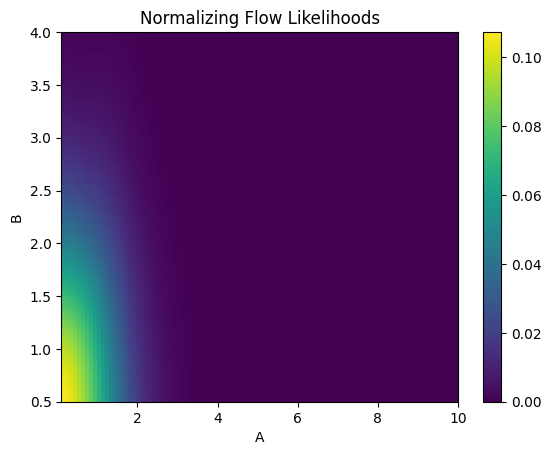

In [15]:
# Plot the normalizing flow likelihoods for verification
plt.imshow(nf_likelihoods, extent=(lowA, highA, lowB, highB), origin='lower', aspect='auto')
plt.title('Normalizing Flow Likelihoods')
plt.xlabel('A')
plt.ylabel('B')
plt.colorbar()
plt.show()